In [2]:
def bootstrap_improvement(protein, start, metric, better, worse, n_bootstrap=10000, random_state=None):
    """
    Compute bootstrapped average percent improvement of `better` relative to `worse` for a given
    `protein`, `start` condition, and `metric` using per-seed results in `all_
    scores_data`.

    - If metric is recall: improvement = (mean_better - mean_worse) / mean_worse * 100
    - If metric is rmse:   improvement = (mean_worse - mean_better) / mean_worse * 100  (reduction)

    Prints LaTeX-formatted summary like: "45 \% [7 \%, 103 \%] improvement in recall".
    Returns a tuple: (mean_improvement, ci_low, ci_high).
    """
    import numpy as np

    # Resolve metric column and display label
    metric_norm = str(metric).strip().lower()
    if metric_norm in {"recall", "recall@2%", "recall_2pc", "recall2pc", "recall@2pct"}:
        metric_col = "recall_2pc"
        metric_label = "recall"
        higher_is_better = True
    elif metric_norm == "rmse":
        metric_col = "rmse"
        metric_label = "rmse"
        higher_is_better = False
    else:
        raise ValueError(f"Unsupported metric: {metric}. Use 'recall' or 'rmse'.")

    # Normalize start to boolean if given as a string
    start_bool = start
    if isinstance(start, str):
        s = start.strip().lower()
        if s in {"bad", "true", "t", "1", "yes", "y", "bad_start", "badstart"}:
            start_bool = True
        elif s in {"random", "false", "f", "0", "no", "n", "random_start", "randomstart"}:
            start_bool = False
        else:
            raise ValueError(f"Unrecognized start value: {start}")

    # Expect global per-seed dataframe
    if "all_scores_data" not in globals():
        raise NameError("Expected global 'all_scores_data' with per-seed metrics.")

    df = all_scores_data  # noqa: F821 - provided by notebook context

    # Filter by condition
    cond_df = df[(df["Protein"] == protein) & (df["bad_start"] == start_bool)]

    # Subset for better and worse methods
    sub_better = cond_df[cond_df["Acquisition"] == better].loc[:, ["seed", metric_col]]
    sub_worse  = cond_df[cond_df["Acquisition"] == worse ].loc[:, ["seed", metric_col]]

    if sub_better.empty or sub_worse.empty:
        raise ValueError("No data found for the specified methods/condition.")

    # Align on common seeds
    dict_better = sub_better.set_index("seed")[metric_col].to_dict()
    dict_worse  = sub_worse.set_index("seed")[metric_col].to_dict()
    common_seeds = sorted(set(dict_better) & set(dict_worse))
    if len(common_seeds) == 0:
        raise ValueError("No overlapping seeds between methods for this condition.")

    values_better = np.array([dict_better[s] for s in common_seeds], dtype=float)
    values_worse  = np.array([dict_worse[s]  for s in common_seeds], dtype=float)

    # Bootstrap over seeds with replacement
    rng = np.random.default_rng(random_state)
    idx = rng.integers(0, len(common_seeds), size=(n_bootstrap, len(common_seeds)))

    means_better = values_better[idx].mean(axis=1)
    means_worse  = values_worse[idx].mean(axis=1)

    # Compute percent improvement; guard against divide-by-zero
    denom = np.where(means_worse == 0.0, 1e-12, means_worse)
    if higher_is_better:
        improvements = (means_better - means_worse) / denom * 100.0
    else:
        improvements = (means_worse - means_better) / denom * 100.0

    mean_imp = float(np.mean(improvements))
    ci_low, ci_high = np.percentile(improvements, [2.5, 97.5])

    # Format LaTeX-friendly output with integer rounding like the example
    mean_str = f"{round(mean_imp):d} \\%"
    low_str  = f"{round(ci_low):d} \\%"
    high_str = f"{round(ci_high):d} \\%"

    print(f"{mean_str} [{low_str}, {high_str}] improvement in {metric_label}")
    return mean_imp, float(ci_low), float(ci_high)


In [23]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import glob
%matplotlib inline
# %matplotlib notebook
import seaborn as sns
font = {'size' : 16}
mpl.rc('font', **font)
mpl.rc('lines', linewidth=1.5)
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, to_rgb
from matplotlib.ticker import MultipleLocator

def register_tintmap(name: str, hex_color: str):
    c = to_rgb('#'+hex_color) if not hex_color.startswith('#') else to_rgb(hex_color)
    cmap = LinearSegmentedColormap.from_list(name, [(1,1,1), c, (0.05,0.05,0.05)], N=256)
    mpl.colormaps.register(cmap, name=name)
    return name

try:
    OI_BLUE    = register_tintmap("OI_BLUE",    "#0072B2")
    OI_ORANGE  = register_tintmap("OI_ORANGE",  "#E69F00")
    OI_MAGENTA = register_tintmap("OI_MAGENTA", "#CC79A7")
    OI_Vermillion = register_tintmap("OI_Vermillion", "#D55E00")
    OI_Bluish_Green = register_tintmap("OI_Bluish_Green", "#009E73")
except:
    pass
to_plot = ['GREEDY', 'UCB', 'AGENT','SIMPLEAGENT', 'GPT5','Qwen3','Deepseek', 'Random']
to_plot_stat = ['GREEDY', 'UCB', 'TS','EI','$\epsilon$-GREEDY', 'Random', 'SIMPLEAGENT', 'GPT5']

In [24]:
from dataclasses import dataclass
from typing import Dict, Iterable
import hashlib
import matplotlib as mpl

@dataclass(frozen=True)
class ClassStyle:
    cmap: str
    base: float = 0.22
    span: float = 0.6
    quantize: int = 4
    jitter: float = 0.05

class AcqStyler:
    """
    Colors per acquisition (class-coherent), and dashes per acquisition (vary within class).
    """
    # IMPORTANT: seaborn expects dash *sequences* like (5,3), not (offset, (5,3))
    _DASH_BANK = [
        (),                 # solid
        (5, 3),             # dashed
        (3, 2, 1.5, 2),     # dashdot
        (10, 3),             # long-dash
        (8, 2, 1.2, 2),     # long-dash dot
        (2, 2, 2, 4)       # dot-dot-dash
    ]

    def __init__(self, class_styles: Dict[str, ClassStyle] | None = None):
        self.class_quant = {"statistical": 5, "agent": 3, "llm": 3, "finetuned": 3, "baseline": 2}
        default = {
            "statistical": ClassStyle(cmap="OI_MAGENTA", quantize=self.class_quant["statistical"]),
            "agent":       ClassStyle(cmap="OI_Bluish_Green", quantize=self.class_quant["agent"]),
            "llm":         ClassStyle(cmap="OI_BLUE", quantize=self.class_quant["llm"]),
            "finetuned":   ClassStyle(cmap="OI_Vermillion", quantize=self.class_quant["finetuned"]),
            "baseline":    ClassStyle(cmap="Greys"),  # color ignored; baseline -> black
        }
        self.class_idx = {"statistical" : 0, "agent": 1, "llm":2, "finetuned":3, "baseline":4}
        self.class_styles = default if class_styles is None else class_styles
        self.acq_to_class: Dict[str, str] = {}
        self.acq_to_idx: Dict[str, int] = {}  
        self.class_counts = {"statistical": 0, "agent": 0, "llm": 0, "finetuned": 0, "baseline": 0}

    def register(self, name: str, klass: str):
        cls = klass.lower()
        self.acq_to_class[name] = cls
        if cls not in self.class_counts:
            self.class_counts[cls] = 0
        # assign next available index
        self.acq_to_idx[name] = self.class_counts[cls]
        self.class_counts[cls] += 1

    def color(self, name: str):
        if name.lower() in {"random", "baseline"} or self.acq_to_class.get(name) == "baseline":
            return "black"
        cls = self._lookup_class(name)
        cs = self.class_styles[cls]
        idx = (self.acq_to_idx.get(name, 0) + self.class_idx[cls]) % self.class_quant[cls]
        cmap = mpl.colormaps.get(cs.cmap)

        Q = max(1, cs.quantize)
        bin_size = cs.span / Q
        bin_idx = idx % Q  # wrap if more items than bins
        center = cs.base + (bin_idx + 0.5) * bin_size
        return cmap(min(0.98, max(0.02, center)))

    def register_many(self, mapping: Dict[str, str]):
        for k, v in mapping.items():
            self.register(k, v)

    def palette(self, levels: Iterable[str]) -> Dict[str, tuple]:
        return {a: self.color(a) for a in levels}

    def line_style(self) -> Dict[str, object]:
        return {"lw":2.5}
        
    def dashes_for(self, levels: Iterable[str], unique_within_class: bool = True) -> Dict[str, tuple]:
        levels = list(levels)
        L = len(self._DASH_BANK)
        lvl_class = {a: self._lookup_class(a) for a in levels}

        dashes: Dict[str, tuple] = {}

        # --- force baselines ---
        for a in levels:
            if lvl_class[a] == "baseline":
                dashes[a] = (1, 1)   # dotted
            #if a == 'UCB':
            #    dashes[a] = (10, 3)           # extra-long dash
        # ------------------------

        if not unique_within_class:
            for a in levels:
                if a not in dashes:
                    # still use hash if not enforcing uniqueness
                    dashes[a] = self._DASH_BANK[self._hash32(a) % L]
            return dashes

        # --- assign by registration order ---
        by_class: Dict[str, list[str]] = {}
        for a in levels:
            if a not in dashes:   # skip baselines
                by_class.setdefault(lvl_class[a], []).append(a)

        for cls, names in by_class.items():
            for a in names:
                idx_in_class = self.acq_to_idx.get(a, 0)
                dashes[a] = self._DASH_BANK[idx_in_class % L]

        return dashes

        
    def order_acqs(self, levels: Iterable[str],
                   class_order=("statistical", "agent", "llm", "baseline")) -> list[str]:
        levels = list(levels)
        return sorted(levels, key=lambda a: (class_order.index(self._lookup_class(a)), a.lower()))

    def prune_class_legend(self, ax):
        handles, labels = ax.get_legend_handles_labels()
        ban = set(self.class_styles.keys()) | {"Class", "Acquisition"}
        kept = [(h, l) for h, l in zip(handles, labels) if l not in ban]
        if kept:
            ax.legend([h for h, _ in kept], [l for _, l in kept],
                      fontsize=12, frameon=False)
        else:
            leg = ax.get_legend()
            if leg:
                leg.remove()

    def _lookup_class(self, name: str) -> str:
        if name.lower() in {"random", "baseline"}:
            return "baseline"
        return self.acq_to_class.get(name, "llm")

    @staticmethod
    def _hash32(s: str) -> int:
        return int(hashlib.sha1(s.encode("utf-8")).hexdigest()[:8], 16)

    def _sample_t(self, name: str, cs: ClassStyle) -> float:
        h = self._hash32(name)
        Q = max(3, cs.quantize)
        bin_size = cs.span / Q
        bin_idx = h % Q
        jitter_unit = ((h // Q) & 0xFFFF) / 0xFFFF
        center = cs.base + (bin_idx + 0.5) * bin_size
        t = center + (jitter_unit - 0.5) * (cs.jitter * bin_size)
        return max(0.02, min(0.98, t))

STYLER = AcqStyler()
to_register = [
    ("GREEDY",       "statistical"), 
    ("TS",           "statistical"),
    ("EI",           "statistical"),
    ("$\epsilon$-GREEDY",    "statistical"),
    ("UCB",          "statistical"),
    ("Qwen3",        "llm"),
    ("GPT5",         "llm"),
    ("SIMPLEAGENT",  "agent"),
    ("AGENT",        "agent"),
    ("Random",       "baseline"),
    ("Deepseek",       "llm"),
]
for name, klass in to_register:
    STYLER.register(name, klass)

In [25]:
def plot_bar(ax, last, legend=True, names=True, x_ticks=True, protein='TYK2'):
    random_baseline = last[last['Acquisition'] == 'Random']['overall_max'].mean()
    startlabel = 'Bad' if last['bad_start'].iloc[0] else 'Random'
    last = last[last['Acquisition'] != 'Random'].copy()
    last['Class'] = last['Acquisition'].map(STYLER.acq_to_class)
    order   = STYLER.order_acqs(last['Acquisition'].unique())
    palette = STYLER.palette(order)

    ax = sns.barplot(data=last, x='overall_max', y='Acquisition', hue='Acquisition',
                    order=order, hue_order=order, errorbar=('pi', 100), legend=False, orient='h', palette=palette, capsize=0.1)

    ax.set_xlim(0.75,1.05)
    ax.set_axisbelow(True)
    ax.set_title(f'{protein}, {startlabel} Start')
    ax.set_xlabel('Max Fitness Achieved')
    ax.set_ylabel('')

    random_line = ax.axvline(x=random_baseline, color='k', linestyle=':', **STYLER.line_style())
    if legend:
        ax.legend([random_line], ["Random"], fontsize=10, loc='lower center')
    # Add labels inside bars with conditional naming
    for j, (bar, label) in enumerate(zip(ax.patches, [o for o in order if o in last.Acquisition.unique()])):
        width = bar.get_width()
        height = bar.get_height()
        
        # Only add label if i % 2 == 0
        if names:
            ax.text(0.76, bar.get_y() + height / 2, label, 
                ha='left', va='center', fontsize=10, rotation=0, 
                color='white', weight='bold')

    ax.set_yticklabels([])

    # X-axis label handling for Figure 2 (adjusted for horizontal orientation)
    if not x_ticks:
        # Left column: remove x-axis labels
        ax.set_xticklabels([])
        ax.set(xlabel=None)
    else:
        # Right column: move x-axis labels to top
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position("top")
    ax.xaxis.grid(True, which='major')
    return ax

In [26]:
def plot_line(ax, df,  legend=True, names=True, x_ticks=True, protein='TYK2', conf=True, y='recall_2pc', std=False):
    df = df[['Acquisition', 'total_labeled', y]].copy()
    if not std:
        df = df.groupby(['Acquisition', 'total_labeled']).mean().reset_index()
    df['Class'] = df['Acquisition'].map(STYLER.acq_to_class)
    order   = STYLER.order_acqs(df['Acquisition'].unique())
    palette = STYLER.palette(order)
    dashes  = STYLER.dashes_for(order)
    # Show legend only on top-right subplot
    ax = sns.lineplot(data=df, x='total_labeled', y=y, hue='Acquisition', style='Acquisition',
                hue_order=order, errorbar=('pi', 100), legend=legend, ax=ax, palette=palette, dashes=dashes, **STYLER.line_style())
    random = df[df['Acquisition'] == 'Random'].groupby('total_labeled')[y].mean().reset_index()
    #ax.plot(random['total_labeled'], random[y], color='black', label='Random', linestyle=':', lw=1)
    if legend: 
        ax.legend(fontsize=12, handlelength=3.5)
    ax.set_xlabel('# Molecules')
    return ax

In [27]:
import os 
os.chdir('/global/cfs/cdirs/m4737/akkem/BO_LLM/mols/analysis')
import sys
sys.path.append('/global/cfs/cdirs/m4737/akkem/BO_LLM/mols')
from utils.DataUtils import get_all_training_repeats
import json
fitness_dict = {'TYK2': pd.read_csv('../data/TYK2.csv')[['SMILES', 'affinity']].set_index('SMILES').to_dict(orient='index'),
                'D2R': pd.read_csv('../data/D2R.csv')[['SMILES', 'affinity']].set_index('SMILES').to_dict(orient='index')}
def get_all_scores(selector_name, target, bad_start):
    repeats = get_all_training_repeats(oracle_name='GPRegOracle', batch_size=60, initial_size=60, selector_name=selector_name, target=target, bad_start=bad_start)
    scores = {'recall_2pc': [], 'overall_max': [], 'rmse': [], 'seed': []}
    for repeat in repeats:
        try:
            results = json.load(open(repeat / "Training_results.json"))
        except:
            print(f"No training results for {repeat}")
            continue
        metrics = results['al_cycles'][-1]['performance_metrics']
        selected = results['al_cycles'][-1]['total_labeled']
        recall = metrics['recall_2pc']
        rmse = metrics['rmse']
        selections = results['al_cycles'][-1]['samples_selected']
        overall_max = max([fitness_dict[target][smi]['affinity'] for smi in selections][:600])
        if  selected > 600:
            selected_prev = results['al_cycles'][-2]['total_labeled']
            recall_prev = results['al_cycles'][-2]['performance_metrics']['recall_2pc']
            rmse_prev = results['al_cycles'][-2]['performance_metrics']['rmse']
            recall = recall_prev + (recall - recall_prev) * (600 - selected_prev) / (selected - selected_prev)
            rmse = rmse_prev + (rmse - rmse_prev) * (600 - selected_prev) / (selected - selected_prev)
        elif selected < 600:
            continue
        scores['recall_2pc'].append(recall)
        scores['overall_max'].append(overall_max)
        scores['rmse'].append(rmse)
        scores['seed'].append(results['experiment_config']['random_seed'])
    return scores

In [28]:
namemap = {'Exploit': 'GREEDY', 'Thompson': 'TS', 'LLMFeaturiseQwen': 'Qwen3', 'LLMFeaturiseGPT': 'GPT5', 
    'LLMFeaturiseLlama': 'Llama4_small','EI': 'EI', 'EpsExploit': '$\epsilon$-GREEDY', 'LLMWorkflow': 'AGENT', 'LLMWorkflowSimple': 'SIMPLEAGENT', 'LLMFat': 'Deepseek', 'Random': 'Random'}
N = 10
from scipy import stats
raw_data_TYK2 = pd.read_csv(f'../data/TYK2.csv')
raw_data_D2R = pd.read_csv(f'../data/D2R.csv')
def normalize(data, protein):
    if protein == 'TYK2':
        min_aff = raw_data_TYK2['affinity'].min()
        max_aff = raw_data_TYK2['affinity'].max()
    else:
        min_aff = raw_data_D2R['affinity'].min()
        max_aff = raw_data_D2R['affinity'].max()
    data['overall_max'] = (data['overall_max'] - min_aff) / (max_aff - min_aff)
    data['rmse'] = data['rmse'] / (max_aff - min_aff)
    data['overall_max_std'] = data['overall_max_std'] / (max_aff - min_aff)
    data['rmse_std'] = data['rmse_std'] / (max_aff - min_aff)
    return data

def read_results():
    glob_path = f"../output/benchmarks/benchmark_*.csv"
    files = glob.glob(glob_path)
    dfs = []
    all_scores_dfs = []
    value_cols = ['recall_2pc','rmse', 'overall_max']
    for file in files:
        if 'beta' in file or 'disable' in file or 'maxseed' in file:
            continue
        params = file.split('_')
        protein = params[1]
        bad_start = params[-1][:-4] == 'Bad'
        selector = params[3]
        scores = get_all_scores(selector, protein, bad_start)
        scores['Acquisition'] = [namemap.get(selector[:-8], selector[:-8]) for _ in range(len(scores['recall_2pc']))]
        scores['Protein'] = [protein for _ in range(len(scores['recall_2pc']))]
        scores['bad_start'] = [bad_start for _ in range(len(scores['recall_2pc']))]
        all_scores_dfs.append(pd.DataFrame(scores))
        n = N if not "Featurise" in selector else 5
        df = pd.read_csv(file)
        df.fillna(1e-8,inplace=True)
        df = normalize(df, protein)
        print(file)
        df_lower = df[value_cols + ['total_labeled'] + [col + '_std' for col in value_cols]].copy()
        df_upper = df[value_cols + ['total_labeled'] + [col + '_std' for col in value_cols]].copy()
        # For 95% confidence interval
        t = stats.t.ppf(0.95, n-1) 
        for x, sub_df in zip([-1,1], [df_lower, df_upper]):
            for col in value_cols:
                sub_df[col] = df[col] + x * df[col + '_std'] # / np.sqrt(n) * t
        df = pd.concat([df_lower, df[value_cols + ['total_labeled'] + [col + '_std' for col in value_cols]].copy(), df_upper]).reset_index(drop=True)
        name = namemap.get(selector[:-8], selector[:-8])
        
        df['Acquisition'] = name
        df['Protein'] = protein
        df['bad_start'] = bad_start

        if name in STYLER.acq_to_class.keys() or name == 'Random':
            dfs.append(df)
    return pd.concat(dfs), pd.concat(all_scores_dfs)

all_data, all_scores_data = read_results()
print(all_data['Acquisition'].unique())

../output/benchmarks/benchmark_TYK2_GPRegOracle_ExploitSelector_60_60_Bad.csv
No training results for /global/cfs/cdirs/m4737/akkem/BO_LLM/mols/output/training/D2R/GPRegOracle_LLMFeaturiseQwenSelector_60_60_6_20250829
No training results for /global/cfs/cdirs/m4737/akkem/BO_LLM/mols/output/training/D2R/GPRegOracle_LLMFeaturiseQwenSelector_60_60_5_20250829
No training results for /global/cfs/cdirs/m4737/akkem/BO_LLM/mols/output/training/D2R/GPRegOracle_LLMFeaturiseQwenSelector_60_60_2_20250829
No training results for /global/cfs/cdirs/m4737/akkem/BO_LLM/mols/output/training/D2R/GPRegOracle_LLMFeaturiseQwenSelector_60_60_3_20250829
No training results for /global/cfs/cdirs/m4737/akkem/BO_LLM/mols/output/training/D2R/GPRegOracle_LLMFeaturiseQwenSelector_60_60_0_20250829
No training results for /global/cfs/cdirs/m4737/akkem/BO_LLM/mols/output/training/D2R/GPRegOracle_LLMFeaturiseQwenSelector_60_60_1_20250829
No training results for /global/cfs/cdirs/m4737/akkem/BO_LLM/mols/output/training/

In [29]:
def plot_all(protein, start, acq_fns, conf=True):
    start_label = 'Bad' if start else 'Random'
    sub_df = all_data[(all_data['Protein'] == protein) & (all_data['bad_start'] == start) & (all_data['Acquisition'].isin(acq_fns))]
    fig, ax = plt.subplots(1,1,figsize=(6, 5))
    ax = plot_line(ax, sub_df, legend=True, names=True, x_ticks=True, protein=f'{protein} {start}', conf=conf, y='recall_2pc')
    ax.set_ylabel('Recall @ 2%')
    ax.set_title(f'{protein}, {start_label} Start')
    plt.show()
    fig, ax = plt.subplots(1,1,figsize=(6, 5))
    ax = plot_line(ax, sub_df, legend=False, names=True, x_ticks=True, protein=f'{protein} {start}', conf=conf, y='rmse')
    ax.set_ylabel('RMSE')
    ax.set_title(f'{protein}, {start_label} Start')
    plt.show()
    fig, ax = plt.subplots(1,1,figsize=(6, 5))
    ax = plot_line(ax, sub_df, legend=False, names=True, x_ticks=True, protein=f'{protein} {start}', conf=conf, y='overall_max')
    ax.set_ylabel('Overall Max')
    ax.set_title(f'{protein}, {start_label} Start')
    plt.show()
    fig2, ax2 = plt.subplots(1,1,figsize=(5, 5))
    plot_bar(ax2, sub_df[sub_df['total_labeled'] == 600], legend=True, names=True, x_ticks=True, protein=f'{protein}')
    plt.show()

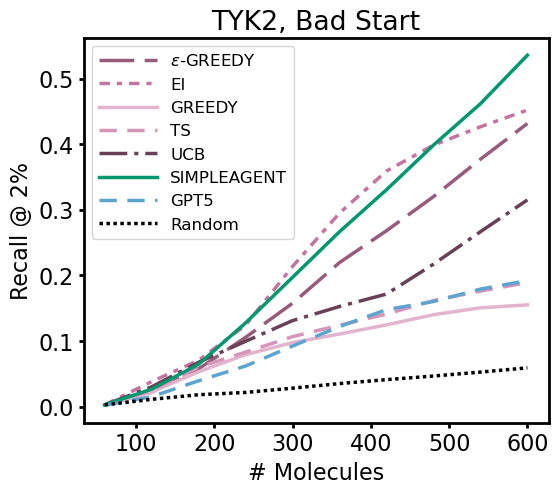

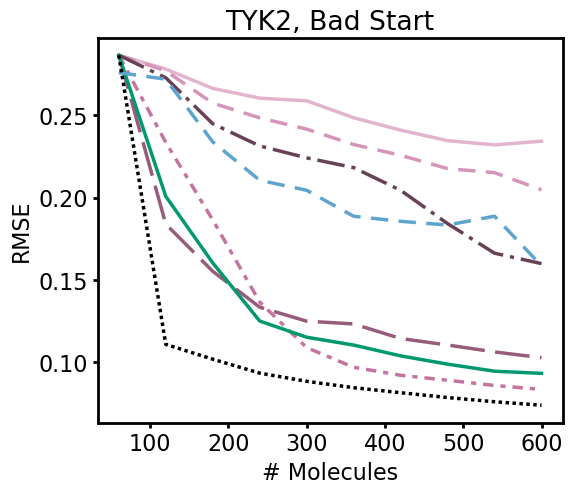

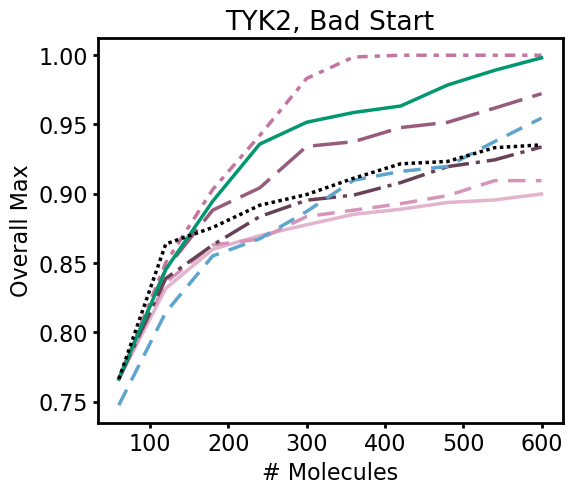

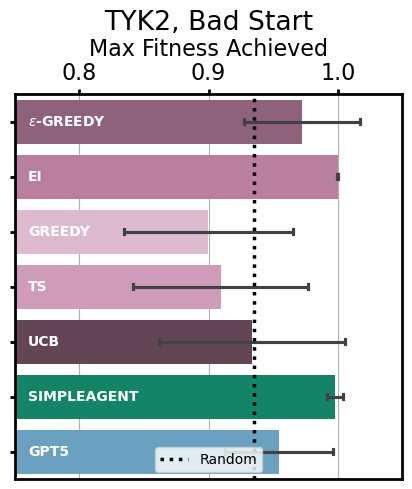

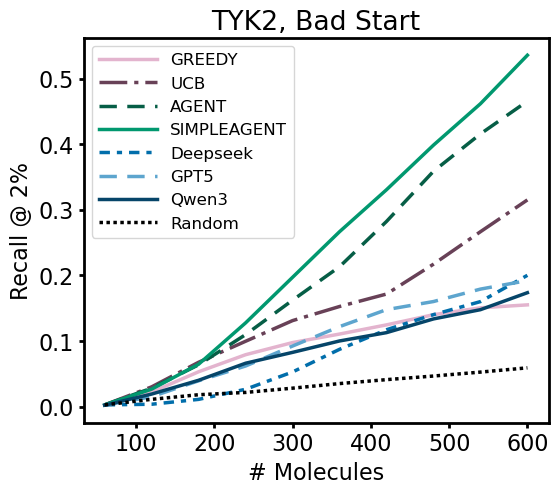

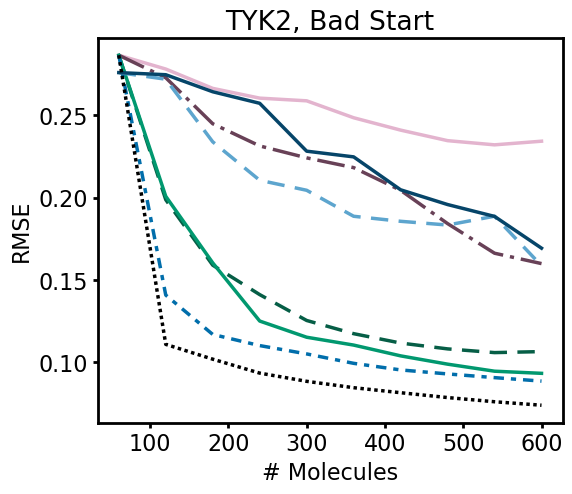

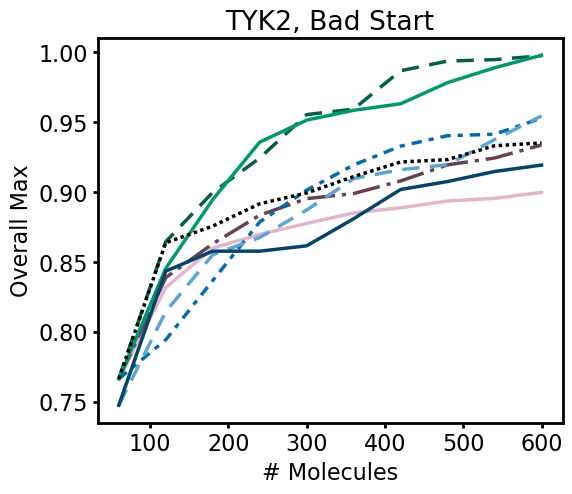

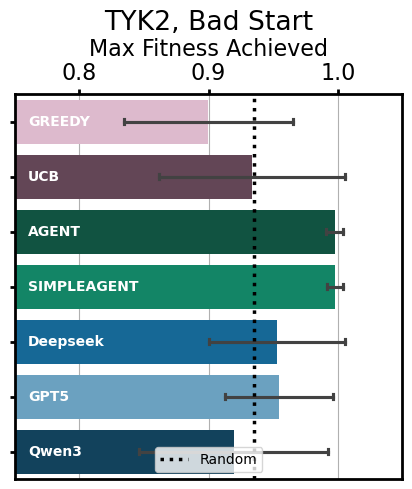

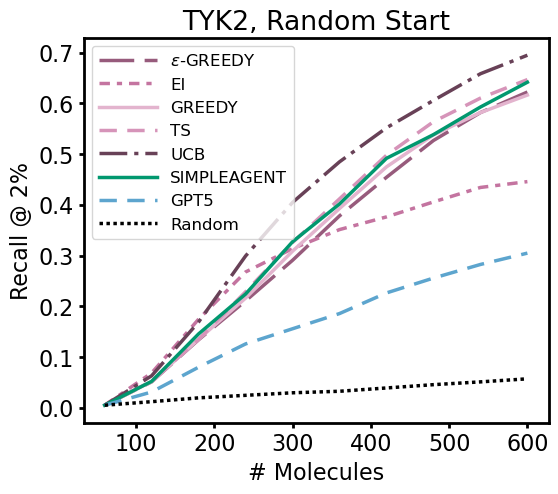

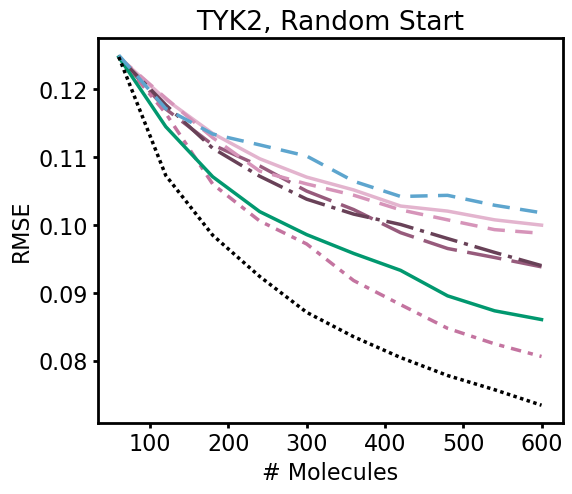

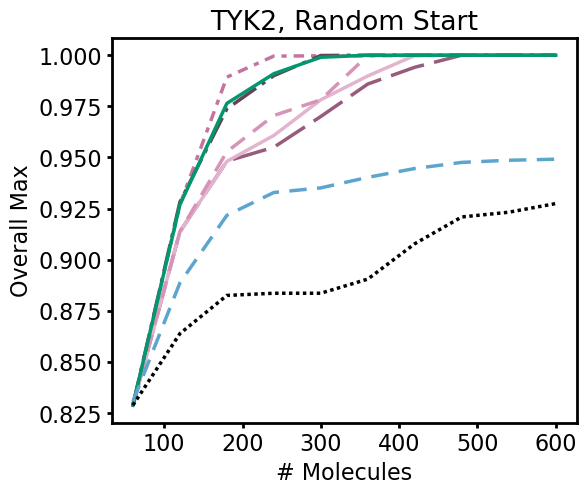

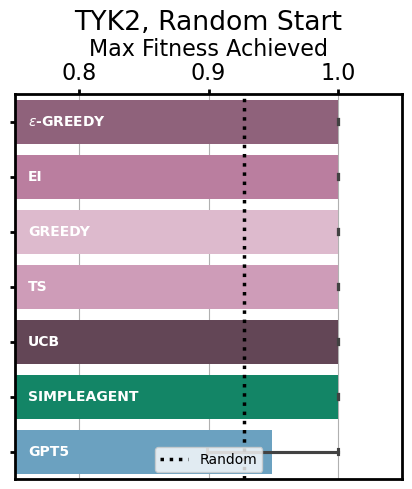

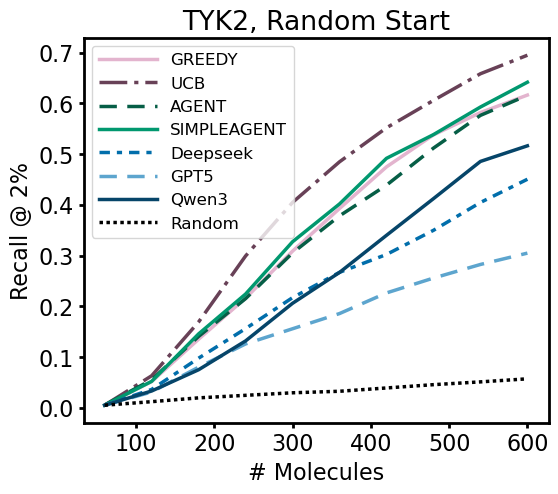

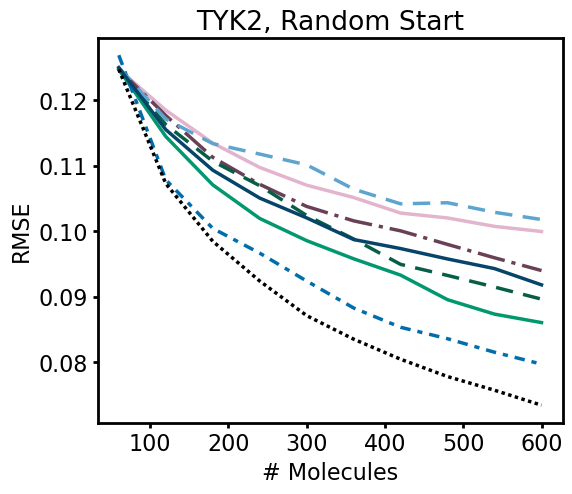

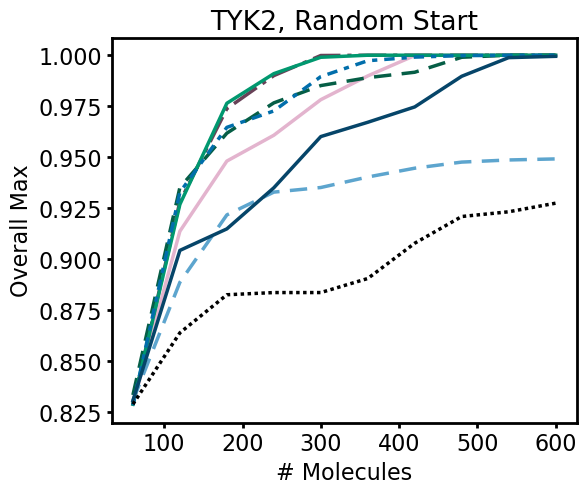

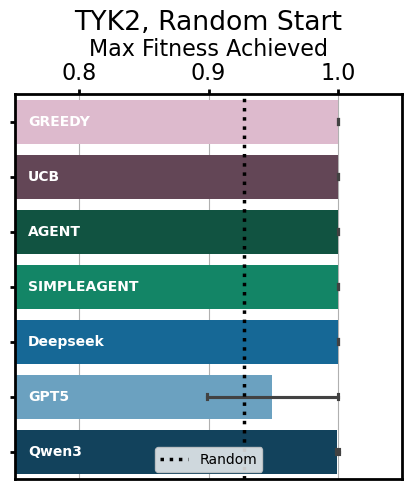

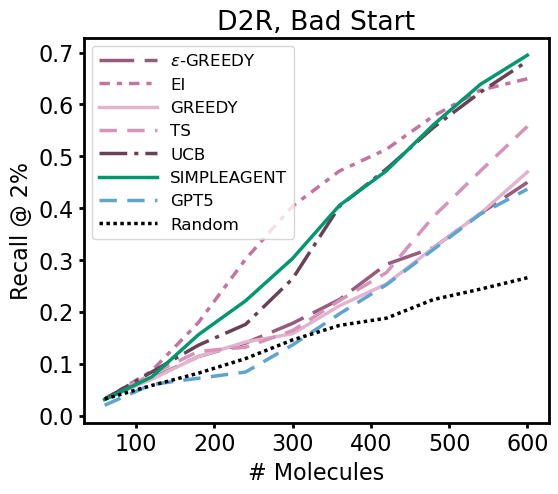

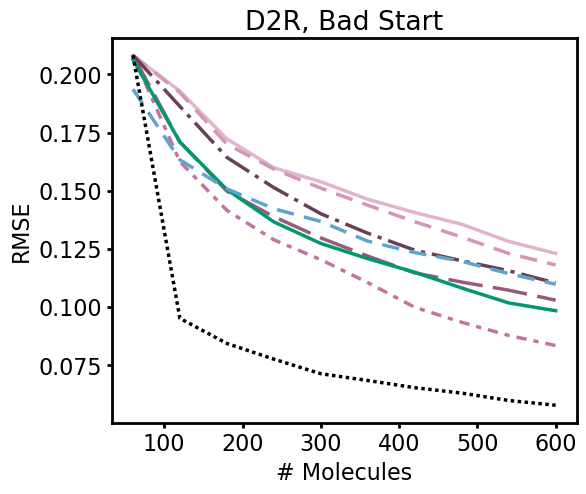

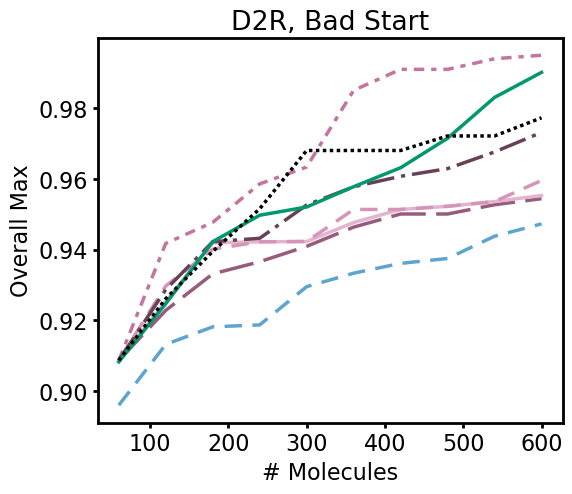

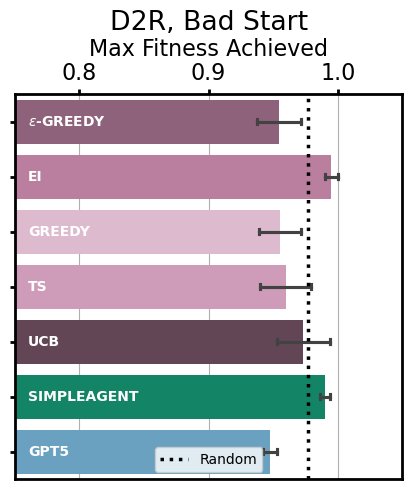

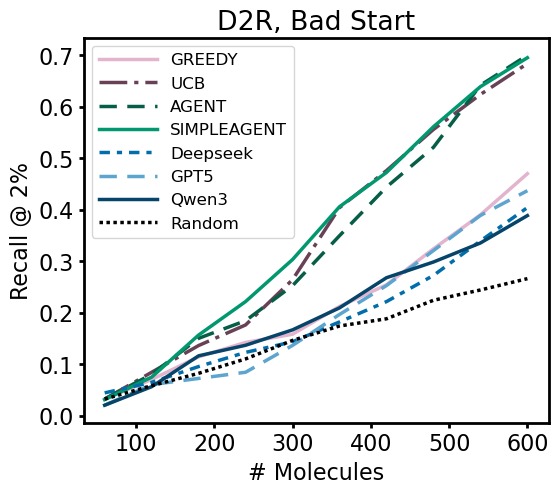

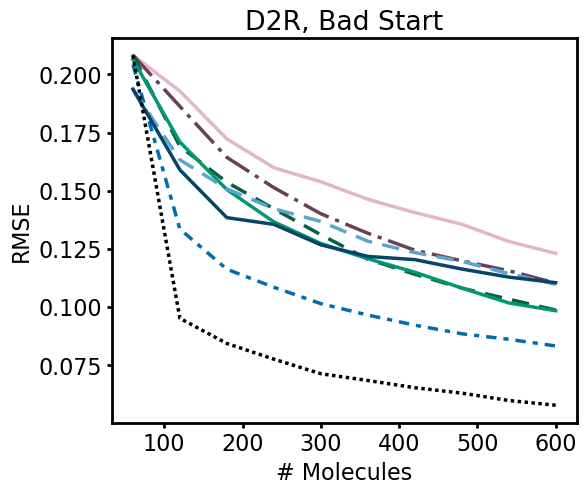

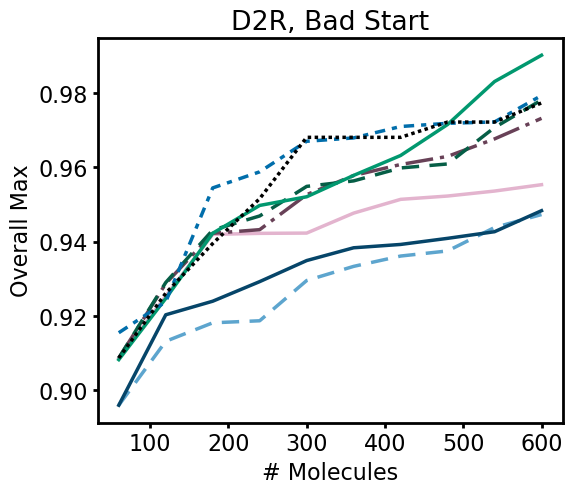

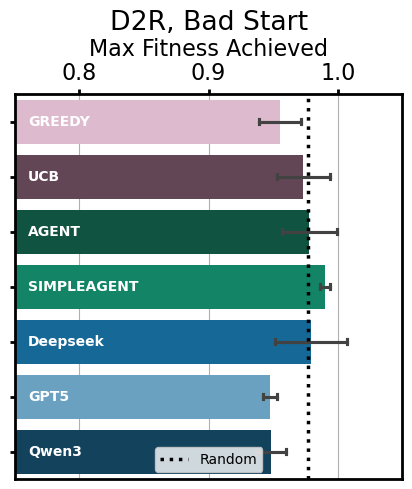

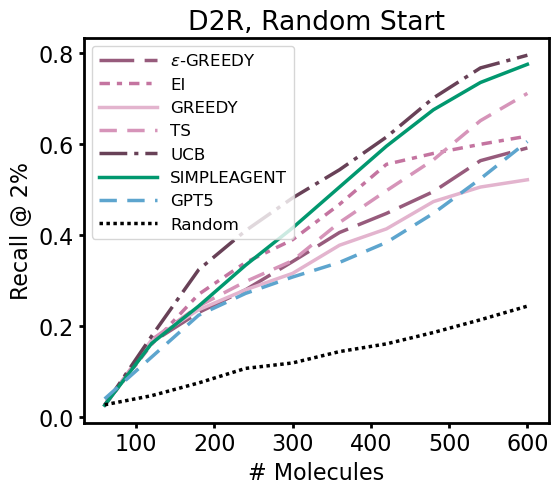

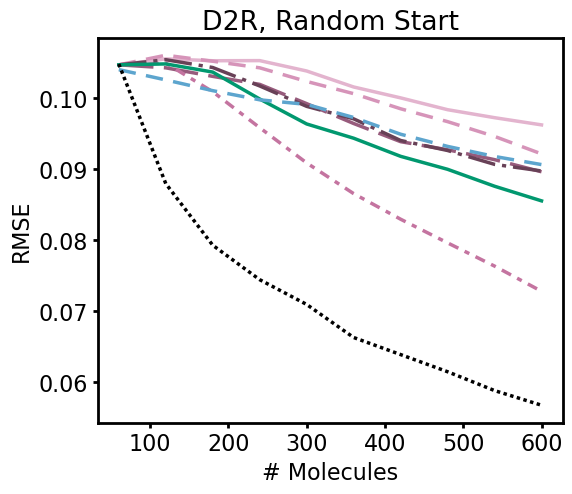

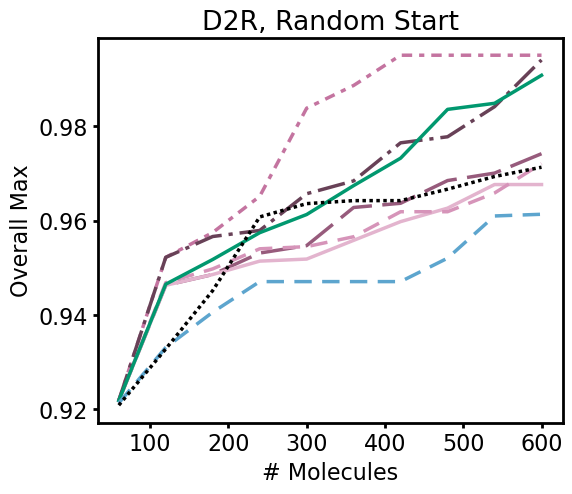

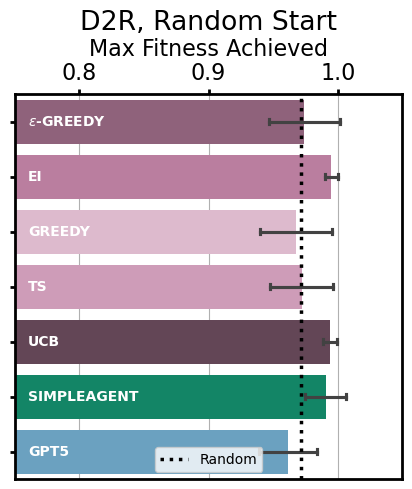

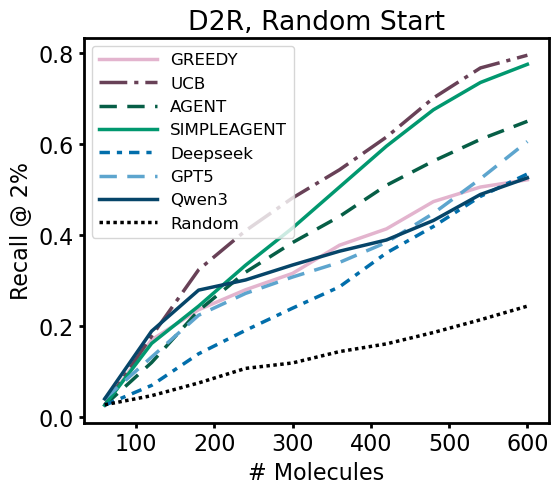

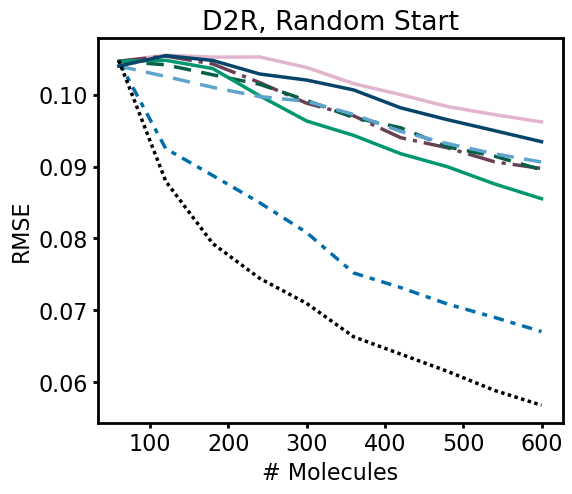

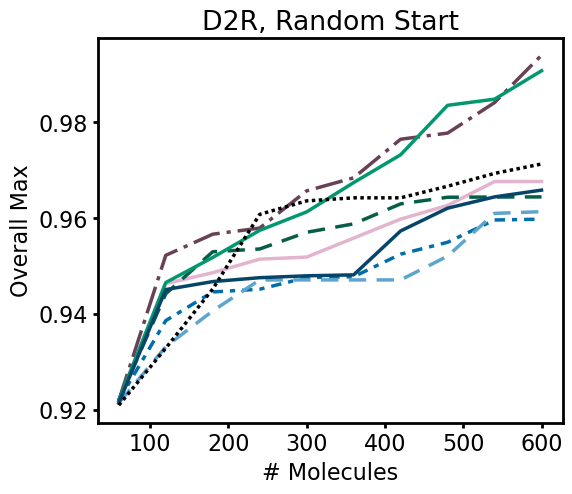

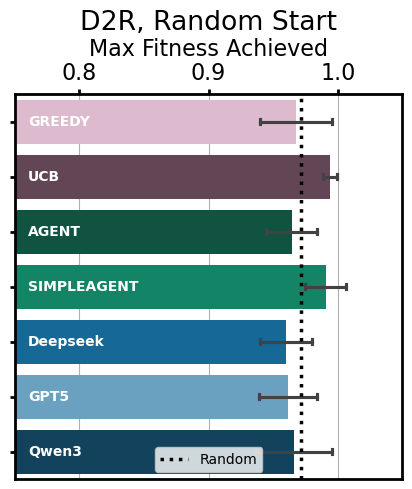

In [30]:
for protein in ['TYK2', 'D2R']:
    for start in [True, False]:
        for acq in [to_plot_stat, to_plot]:
            plot_all(protein, start, acq)

In [31]:
import pandas as pd
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
order = ['GREEDY', 'UCB','TS', 'EI','$\epsilon$-GREEDY','AGENT','SIMPLEAGENT', 'Deepseek','GPT5','Qwen3']

In [12]:
ucb = all_scores_data[all_scores_data['Acquisition'] == 'UCB']
simpleagent = all_scores_data[all_scores_data['Acquisition'] == 'SIMPLEAGENT']

union = pd.merge(ucb, simpleagent, on=['seed', 'Protein', 'bad_start'], suffixes=('_ucb', '_simpleagent'))
union['diff_recall'] = union['recall_2pc_ucb'] - union['recall_2pc_simpleagent']
union['diff_rmse'] = union['rmse_ucb'] - union['rmse_simpleagent']

print(union[['seed', 'Protein', 'bad_start', 'diff_recall', 'diff_rmse']])

    seed Protein  bad_start  diff_recall  diff_rmse
0     50    TYK2       True    -0.070021   0.155398
1     46    TYK2       True    -0.385116   1.052105
2     44    TYK2       True    -0.055017   0.289692
3     42    TYK2       True    -0.486146   1.093822
4     45    TYK2       True     0.030009   1.030297
5     49    TYK2       True    -0.315095   1.020749
6     43    TYK2       True    -0.485146   1.100891
7     47    TYK2       True    -0.105032   0.153649
8     51    TYK2       True    -0.230069   0.369606
9     48    TYK2       True    -0.105032   0.196355
10    45    TYK2      False     0.100363   0.067614
11    51    TYK2      False     0.160048   0.051310
12    46    TYK2      False    -0.011420   0.155838
13    47    TYK2      False     0.000000   0.122323
14    44    TYK2      False    -0.015005   0.086259
15    50    TYK2      False     0.045014   0.092700
16    48    TYK2      False     0.085026   0.031755
17    42    TYK2      False     0.065020   0.044948
18    43    

In [ ]:
def is_significantly_different(subdf1, subdf2, n_samples=10000, 
                              metric_type='recall_2pc', threshold=0.95):
    dict1 = subdf1.loc[:, ['seed', metric_type]].set_index('seed')[metric_type].to_dict()
    dict2 = subdf2.loc[:,['seed', metric_type]].set_index('seed')[metric_type].to_dict()
    
    seed_range = list(set(dict1.keys()) & set(dict2.keys()))
    if len(seed_range) != 10:
        print(seed_range)

    values1 = np.array([dict1[seed] for seed in seed_range])
    values2 = np.array([dict2[seed] for seed in seed_range])

    seeds_idx = np.random.choice(len(seed_range), size=(n_samples, len(seed_range)), replace=True)
    samples1 = values1[seeds_idx]  # Shape: (n_samples, len(seed_range))
    samples2 = values2[seeds_idx]  # Shape: (n_samples, len(seed_range))

    means1 = np.mean(samples1, axis=1)  # Shape: (n_samples,)
    means2 = np.mean(samples2, axis=1)  # Shape: (n_samples,)


    # Vectorized comparison
    if metric_type == 'recall_2pc' or metric_type == 'overall_max':
        prob_better = np.mean(means1 > means2)
    else:  # rmse
        prob_better = np.mean(means1 < means2)
    
    # Significant if probability is very high or very low
    print(f'N = {len(seed_range)}, P({subdf1["Acquisition"].iloc[0]} better than {subdf2["Acquisition"].iloc[0]}) = {prob_better}')
    return prob_better > threshold

def format_value_with_std(mean, std):
    """Format a value with its standard deviation."""
    return f"{mean:.2f} $\\pm$ {std:.2f}"

def make_bold_if_needed(value_str, is_significant):
    """Make a value bold if it's significantly different."""
    if is_significant:
        return f"\\textbf{{{value_str}}}"
    return value_str

def generate_latex_table(df, n_samples=10, bold='significance'):
    """
    Generate a LaTeX table from the DataFrame with significance testing.
    
    Parameters:
    df: DataFrame with columns:
        - Acquisition: method name
        - Protein: 'TYK2' or 'D2R'
        - bad_start: True or False
        - rmse, rmse_std: RMSE values and standard deviations
        - recall_2pc, recall_2pc_std: Recall@2% values and standard deviations
        - overall_max, overall_max_std: (optional) overall max values
    bold: 'max' or 'significance', if 'max' then bold best mean in column, if 'significance' then bold if significantly different using bootstrap
    """
    
    # Define statistical methods
    statistical_methods = ['GREEDY', 'TS', 'UCB', 'EI','$\epsilon$-GREEDY']
    
    # Define the conditions
    conditions = [
        ('TYK2', True, 'TYK2 Bad Start'),
        ('TYK2', False, 'TYK2 Random Start'),
        ('D2R', True, 'D2R Bad Start'),
        ('D2R', False, 'D2R Random Start')
    ]
        
    # Start building the LaTeX table
    latex_lines = []
    latex_lines.append("\\begin{table}[h]")
    latex_lines.append("\\centering")
    latex_lines.append("\\begin{tabular}{l" + "cc" * len(conditions) + "}")
    latex_lines.append("\\hline")
    
    # Create the header rows
    # First row: super headers
    header1 = "\\multirow{2}{*}{Method}"
    for _, _, condition_name in conditions:
        header1 += f" & \\multicolumn{{2}}{{c}}{{{condition_name}}}"
    header1 += " \\\\"
    latex_lines.append(header1)
    
    # Second row: sub headers
    header2 = ""
    for _ in conditions:
        header2 += " & Recall@2\\% $\\uparrow$ & MAX $\\uparrow$"
    header2 += " \\\\"
    #for _ in conditions:
    #    header2 += " &  & $\\times 10^{-3}$"
    #header2 += " \\\\"
    latex_lines.append(header2)
    latex_lines.append("\\hline")
    
    conditions_max = df.groupby(['Protein', 'bad_start'])[['recall_2pc', 'overall_max']].max().reset_index()
    # Process each method
    for method in order:
        line = method
        
        for protein, bad_start, _ in conditions:
            score_subdf = all_scores_data[(all_scores_data['Protein'] == protein) & (all_scores_data['bad_start'] == bad_start)]
            # Filter data for this specific condition and method
            condition_data = df[
                (df['Acquisition'] == method) & 
                (df['Protein'] == protein) & 
                (df['bad_start'] == bad_start)
            ]
            condition_max = conditions_max[(conditions_max['Protein'] == protein) 
                & (conditions_max['bad_start'] == bad_start)]
            
            if len(condition_data) == 0:
                # No data for this combination
                line += " & - & -"
                continue
            
            # Get the values (assuming one row per condition)
            row = condition_data.iloc[0]
            
            recall_mean = row.get('recall_2pc', 0)
            recall_std = row.get('recall_2pc_std', 0)
            max_mean = row.get('overall_max', 0)
            max_std = row.get('overall_max_std', 0)
            
            # Format values
            recall_str = f"{recall_mean:.2f} $\\pm$ {recall_std:.2f}"
            max_str = f"{max_mean:.2f} $\\pm$ {max_std:.2f}"
            
            if bold == 'significance':
                # Find best statistical method for this condition
                if method in statistical_methods:
                    stat_data = df[
                        (~df['Acquisition'].isin(statistical_methods + ['Random'])) & 
                        (df['Protein'] == protein) & 
                        (df['bad_start'] == bad_start)
                    ]
                else:
                    stat_data = df[
                        (df['Acquisition'].isin(statistical_methods)) & 
                        (df['Protein'] == protein) & 
                        (df['bad_start'] == bad_start)
                    ]
                
                if len(stat_data) > 0:
                    # Find best recall (highest)
                    best_recall_idx = stat_data['recall_2pc'].idxmax()
                    best_stat_method_recall = stat_data.loc[best_recall_idx, 'Acquisition']
                    
                    # Find best RMSE (lowest)
                    best_max_idx = stat_data['overall_max'].idxmax()
                    best_stat_method_max = stat_data.loc[best_max_idx, 'Acquisition']
                    subdf1 = score_subdf[score_subdf['Acquisition'] == method]
                    subdf2 = score_subdf[score_subdf['Acquisition'] == best_stat_method_recall]
                    subdf3 = score_subdf[score_subdf['Acquisition'] == best_stat_method_max]
                    # Check significance
                    recall_sig = is_significantly_different(
                        subdf1, subdf2,
                        metric_type='recall_2pc'
                    )
                    max_sig = is_significantly_different(
                        subdf1, subdf3,
                        metric_type='overall_max'
                    )
                    
                    recall_str = make_bold_if_needed(recall_str, recall_sig)
                    max_str = make_bold_if_needed(max_str, max_sig)
            elif bold == 'max':
                if recall_mean > condition_max['recall_2pc'].values[0]*0.99:
                    recall_str = f"\\textbf{{{recall_str}}}"
                if max_mean > condition_max['overall_max'].values[0]*0.99:
                    max_str = f"\\textbf{{{max_str}}}"
            line += f" & {recall_str} & {max_str}"
        
        line += " \\\\"
        latex_lines.append(line)
    
    # Close the table
    latex_lines.append("\\hline")
    latex_lines.append("\\end{tabular}")
    latex_lines.append("\\caption{Performance comparison across different methods and conditions. Bold values indicate statistically significant differences from the best statistical method (Bayesian posterior probability > 0.95).}")
    latex_lines.append("\\label{tab:results}")
    latex_lines.append("\\end{table}")
    
    return "\n".join(latex_lines)

    
sub_df = all_data[all_data['total_labeled'] == 600].groupby(['Protein', 'bad_start', 'Acquisition']).mean().reset_index()
# Generate the LaTeX table
latex_table = generate_latex_table(sub_df, bold='max')
print("Generated LaTeX table:")
print(latex_table)
print("\n" + "="*50 + "\n")
print("Note: Don't forget to include \\usepackage{multirow} in your LaTeX preamble!")

Condition:  TYK2 True
Condition:  TYK2 False
Condition:  D2R True
Condition:  D2R False
Condition:  TYK2 True
Condition:  TYK2 False
Condition:  D2R True
Condition:  D2R False
Condition:  TYK2 True
Condition:  TYK2 False
Condition:  D2R True
Condition:  D2R False
Condition:  TYK2 True
Condition:  TYK2 False
Condition:  D2R True
Condition:  D2R False
Condition:  TYK2 True
Condition:  TYK2 False
Condition:  D2R True
Condition:  D2R False
Condition:  TYK2 True
Condition:  TYK2 False
Condition:  D2R True
Condition:  D2R False
Condition:  TYK2 True
Condition:  TYK2 False
Condition:  D2R True
Condition:  D2R False
Condition:  TYK2 True
Condition:  TYK2 False
Condition:  D2R True
Condition:  D2R False
Condition:  TYK2 True
Condition:  TYK2 False
Condition:  D2R True
Condition:  D2R False
Condition:  TYK2 True
Condition:  TYK2 False
Condition:  D2R True
Condition:  D2R False
Generated LaTeX table:
\begin{table}[h]
\centering
\begin{tabular}{lcccccccc}
\hline
\multirow{2}{*}{Method} & \multicol

## Compute average rank and overall dominance

In [ ]:
def compute_combined_ranks(
    df_seedlevel,
    statistical_methods=('GREEDY','TS','UCB','EI', '$\epsilon$-GREEDY'),
    metric_types=('recall_2pc','overall_max'),
    n_samples=10000,
    tasks_cols=('Protein','bad_start'),
    verbose=False,
):
    """
    Returns a DataFrame of expected average ranks (+95% CI) across ALL tasks and ALL given metric_types.
    - metric_types can be a str or list[str]
    - Ranks use competition ranking (ties share the higher rank), 1 = best.
    - Removes dominance P-test from the original.
    """

    # --- normalize inputs ---
    if isinstance(metric_types, str):
        metric_types = [metric_types]
    metric_types = list(metric_types)

    tasks = list(df_seedlevel[list(tasks_cols)].drop_duplicates().itertuples(index=False, name=None))
    all_methods = df_seedlevel['Acquisition'].unique().tolist()
    stats_set = set(statistical_methods)
    nonstat_methods = [m for m in all_methods if m not in stats_set and m != 'Random']

    # --- build (metric -> (method, task) -> {seed: value}) cache ---
    mt_seedval = {mt:{} for mt in metric_types}
    for mt in metric_types:
        sub = df_seedlevel.dropna(subset=[mt])
        for m in all_methods:
            sub_m = sub[sub['Acquisition']==m]
            if sub_m.empty: 
                continue
            for t in tasks:
                filt = sub_m.copy()
                for col,v in zip(tasks_cols, t):
                    filt = filt[filt[col]==v]
                if filt.empty: 
                    continue
                d = filt.loc[:, ['seed', mt]].set_index('seed')[mt].to_dict()
                if d:
                    mt_seedval[mt][(m,t)] = d

    # --- helpers ---
    def seeds_for(metric, methods, task):
        sets = []
        for m in methods:
            sets.append(set(mt_seedval[metric].get((m,task), {}).keys()))
        return sorted(set.intersection(*sets)) if sets else []

    def ci95(x):
        x = np.asarray(x, float)
        return float(np.mean(x)), float(np.percentile(x,2.5)), float(np.percentile(x,97.5))

    results_rows = []

    for a in nonstat_methods:
        # which statistical baselines are present for *all* tasks and *all* metrics?
        stats_present = []
        for s in statistical_methods:
            ok = True
            for mt in metric_types:
                for t in tasks:
                    if (a,t) not in mt_seedval[mt] or (s,t) not in mt_seedval[mt]:
                        ok = False; break
                if not ok: break
            if ok: stats_present.append(s)

        if not stats_present:
            if verbose:
                print(f"[WARN] No statistical baselines present across all tasks & metrics for {a}. Skipping.")
            continue

        compare_set = [a] + stats_present
        w_methods = {m: np.empty(n_samples, dtype=float) for m in compare_set}

        for b in range(n_samples):
            ok = True
            # accumulate ranks over all task × metric
            per_m_ranks = {m: [] for m in compare_set}

            for mt in metric_types:
                for t in tasks:
                    seed_range = seeds_for(mt, compare_set, t)
                    if not seed_range:
                        ok = False
                        if verbose: 
                            print(f"[WARN] Empty seed intersection for {(mt,t)}; draw {b}.")
                        break
                    # bootstrap seeds for this (metric, task)
                    idx = np.random.choice(len(seed_range), size=len(seed_range), replace=True)
                    chosen = [seed_range[i] for i in idx]

                    # compute means per method
                    vals = {
                        m: np.mean([mt_seedval[mt][(m,t)][s] for s in chosen], dtype=float)
                        for m in compare_set
                    }
                    # competition ranking (1=best), ties share higher rank
                    s = pd.Series(vals)
                    ranks = s.rank(method='min', ascending=False)  # higher is better
                    for m in compare_set:
                        per_m_ranks[m].append(float(ranks[m]))

                if not ok: break
            if not ok:
                for m in compare_set: w_methods[m][b] = np.nan
                continue

            # average rank across all task×metric
            for m in compare_set:
                w_methods[m][b] = np.mean(per_m_ranks[m])

        # drop NaNs
        valid = ~np.isnan(w_methods[a])
        if not np.any(valid):
            if verbose: 
                print(f"[WARN] No valid draws for {a}.")
            continue
        for m in compare_set:
            w_methods[m] = w_methods[m][valid]

        # build result row (main method + optional columns for each baseline, like the original)
        row = {
            'Acquisition': a,
            'num_tasks': len(tasks),
            'metrics_used': ','.join(metric_types),
            'compared_against': ','.join(stats_present),
        }
        m, lo, hi = ci95(w_methods[a])
        row['expected_rank'] = m
        row['rank_ci_low']   = lo
        row['rank_ci_high']  = hi

        for s in stats_present:
            m, lo, hi = ci95(w_methods[s])
            row[f'expected_rank_{s}'] = m
            row[f'rank_ci_low_{s}']   = lo
            row[f'rank_ci_high_{s}']  = hi

        results_rows.append(row)

    results = pd.DataFrame(results_rows).sort_values(['expected_rank','Acquisition']).reset_index(drop=True)
    return results

statistical_methods = ['GREEDY','TS','EI', '$\epsilon$-GREEDY']
results_combined = compute_combined_ranks(
    df_seedlevel=all_scores_data[all_scores_data['Acquisition'].isin(statistical_methods + ['UCB'])],
    statistical_methods=statistical_methods,
    metric_types=['recall_2pc'],
    n_samples=10000,
    tasks_cols=('Protein','bad_start'),
    verbose=False
)
print(results_combined)

   Acquisition  num_tasks metrics_used                    compared_against  \
0  SIMPLEAGENT          4   recall_2pc  GREEDY,TS,UCB,EI,$\epsilon$-GREEDY   

   expected_rank  rank_ci_low  rank_ci_high  expected_rank_GREEDY  \
0         1.8129          1.5           2.5              5.487525   

   rank_ci_low_GREEDY  rank_ci_high_GREEDY  ...  rank_ci_high_TS  \
0                5.25                 5.75  ...              4.0   

   expected_rank_UCB  rank_ci_low_UCB  rank_ci_high_UCB  expected_rank_EI  \
0             1.9452              1.5              2.25           3.84835   

   rank_ci_low_EI  rank_ci_high_EI  expected_rank_$\epsilon$-GREEDY  \
0             3.5             4.25                         4.270425   

   rank_ci_low_$\epsilon$-GREEDY  rank_ci_high_$\epsilon$-GREEDY  
0                           3.75                            4.75  

[1 rows x 22 columns]


### Utility block to compute bootstraped statistics on individual comparisons

In [18]:
def bootstrap_improvement(protein, start, metric, better, worse, n_bootstrap=10000, random_state=None):
    # Resolve metric column and display label
    metric_norm = str(metric).strip().lower()
    if metric_norm in {"recall", "recall@2%", "recall_2pc", "recall2pc", "recall@2pct"}:
        metric_col = "recall_2pc"
        metric_label = "recall"
        higher_is_better = True
    elif metric_norm == "rmse":
        metric_col = "rmse"
        metric_label = "RMSE"
        higher_is_better = False
    else:
        raise ValueError(f"Unsupported metric: {metric}. Use 'recall' or 'rmse'.")

    # Normalize start to boolean if given as a string
    start_bool = start
    if isinstance(start, str):
        s = start.strip().lower()
        if s in {"bad", "poor", "true", "t", "1", "yes", "y", "bad_start", "badstart"}:
            start_bool = True
        elif s in {"random", "good", "false", "f", "0", "no", "n", "random_start", "randomstart"}:
            start_bool = False
        else:
            raise ValueError(f"Unrecognized start value: {start}")

    # Filter by condition
    cond_df = all_scores_data[(all_scores_data["Protein"] == protein) & (all_scores_data["bad_start"] == start_bool)]

    # Subset for better and worse methods
    sub_better = cond_df[cond_df["Acquisition"] == better].loc[:, ["seed", metric_col]]
    sub_worse  = cond_df[cond_df["Acquisition"] == worse ].loc[:, ["seed", metric_col]]

    if sub_better.empty or sub_worse.empty:
        raise ValueError("No data found for the specified methods/condition.")

    # Align on common seeds
    dict_better = sub_better.set_index("seed")[metric_col].to_dict()
    dict_worse  = sub_worse.set_index("seed")[metric_col].to_dict()
    common_seeds = sorted(set(dict_better) & set(dict_worse))
    if len(common_seeds) == 0:
        raise ValueError("No overlapping seeds between methods for this condition.")

    values_better = np.array([dict_better[s] for s in common_seeds], dtype=float)
    values_worse  = np.array([dict_worse[s]  for s in common_seeds], dtype=float)

    # Bootstrap over seeds with replacement
    rng = np.random.default_rng(random_state)
    idx = rng.integers(0, len(common_seeds), size=(n_bootstrap, len(common_seeds)))

    means_better = values_better[idx].mean(axis=1)
    means_worse  = values_worse[idx].mean(axis=1)

    # Compute percent improvement; guard against divide-by-zero
    denom = np.where(means_worse == 0.0, 1e-12, means_worse)
    if higher_is_better:
        improvements = (means_better - means_worse) / denom * 100.0
    else:
        improvements = (means_worse - means_better) / denom * 100.0

    mean_imp = float(np.mean(improvements))
    ci_low, ci_high = np.percentile(improvements, [2.5, 97.5])

    # Format LaTeX-friendly output with integer rounding like the example
    mean_str = f"{round(mean_imp):d} \\%"
    low_str  = f"{round(ci_low):d} \\%"
    high_str = f"{round(ci_high):d} \\%"

    print(f"$\Delta={mean_str} \ [{low_str}, {high_str}]$, {better} vs {worse}")
    return mean_imp, float(ci_low), float(ci_high)
print(all_scores_data.Acquisition.unique())

['GREEDY' 'Qwen3' 'Random' 'SIMPLEAGENT' 'Deepseek' 'UCB'
 '$\\epsilon$-GREEDY' 'AGENT' 'EI' 'GPT5' 'TS']


In [19]:
bootstrap_improvement('D2R', "good", 'rmse', 'SIMPLEAGENT', 'UCB')

$\Delta=5 \% \ [1 \%, 8 \%]$, SIMPLEAGENT vs UCB


(4.628369537619852, 1.3327220077970783, 8.000567401936618)

# UCB sensitivity  analysis 

In [20]:
def read_ucb_sensitivity(path):
    files = glob.glob(path)
    dfs = []
    for file in files:
        df = pd.read_csv(file)
        beta = float(file.split('_')[-1][:-4])
        df['beta'] = beta
        dfs.append(df)
    return pd.concat(dfs)
dfs = []
for protein in ['D2R', 'TYK2']:
    for bad_start in [True, False]:
        ucb_sensitivity = read_ucb_sensitivity(path = f'../output/benchmarks/benchmark_{protein}_GPR*_UCB*{"Bad" if bad_start else "Random"}_beta*.csv')
        simpleagent = all_data[(all_data['Acquisition'] == 'SIMPLEAGENT') & (all_data['Protein'] == protein) & (all_data['bad_start'] == bad_start)][['total_labeled', 'recall_2pc']].groupby('total_labeled').mean().reset_index()
        dfs.append({'ucb': ucb_sensitivity, 'simpleagent': simpleagent, 'protein': protein, 'bad_start': bad_start})

In [21]:
def  plot_sensitivity(ucb_sensitivity, simpleagent):
    # Use OI_Magenta colormap with capped range for better contrast on white background
    # Map to range 0.3-0.9 to avoid too bright/light colors
    beta_values = ucb_sensitivity['beta'].unique()
    beta_min, beta_max = ucb_sensitivity['beta'].min(), ucb_sensitivity['beta'].max()
    
    # Create colormap with capped range
    cmap = plt.cm.get_cmap("OI_MAGENTA")
    
    # make plot
    fig, ax = plt.subplots()
    
    # Plot each beta value as a separate line with color from colormap
    for i, beta in enumerate(sorted(beta_values)):
        beta_data = ucb_sensitivity[ucb_sensitivity['beta'] == beta]
        # Map beta to capped colormap range (0.3 to 0.9 to avoid bright colors)
        color_val = 0.3 + 0.6 * (beta - beta_min) / (beta_max - beta_min)
        color = cmap(color_val)
        ax.plot(beta_data['total_labeled'], beta_data['recall_2pc'], 
                color=color, alpha=0.6, linewidth=1.5)
    
    # Create colorbar with the capped range
    norm = plt.Normalize(beta_min, beta_max)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    
    # Add colorbar
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Beta', rotation=270, labelpad=15)
    
    # Plot simpleagent with dashed line
    plt.plot(simpleagent['total_labeled'], simpleagent['recall_2pc'], 
             color="#009E73", label='SIMPLEAGENT', lw=2.5, linestyle='--')
    beta_data = ucb_sensitivity[ucb_sensitivity['beta'] == 4.0]
    plt.plot(beta_data['total_labeled'], beta_data['recall_2pc'], 
             color="#CC79A7", label='UCB', lw=2.5, linestyle='--')
    
    plt.legend()

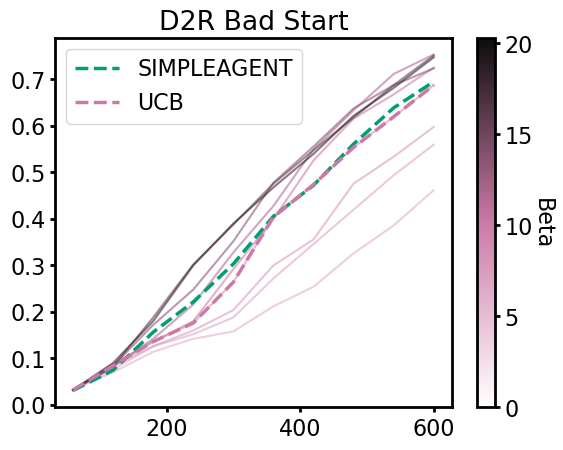

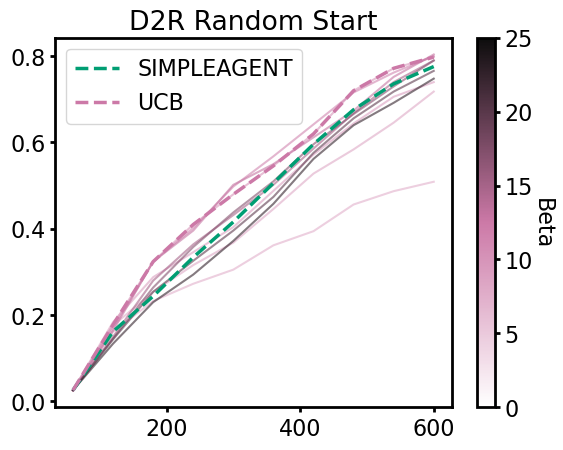

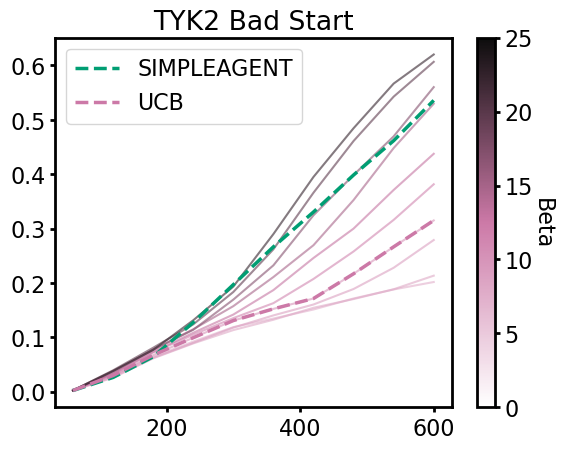

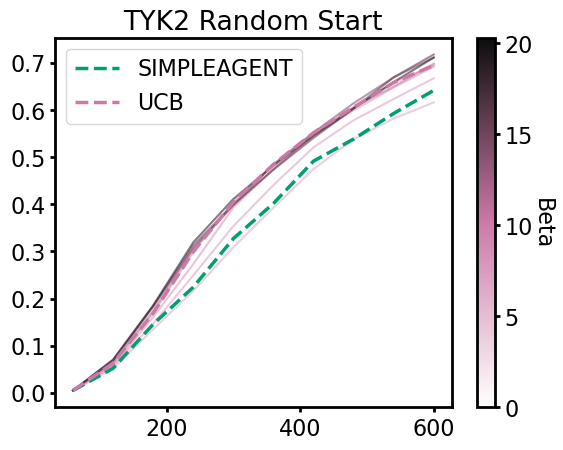

In [22]:
for d in dfs:
    plot_sensitivity(d['ucb'], d['simpleagent'])
    plt.title(f'{d["protein"]} {"Bad" if d["bad_start"] else "Random"} Start')
    plt.show()

# Tool abolition

In [32]:
simpleagent_D2R = all_data[(all_data['Acquisition'].isin(['SIMPLEAGENT', 'GREEDY'])) & (all_data['Protein'] == 'D2R') & (all_data['bad_start'] == False)]
simpleagent_TYK2 = all_data[(all_data['Acquisition'].isin(['SIMPLEAGENT', 'GREEDY'])) & (all_data['Protein'] == 'TYK2') & (all_data['bad_start'] == True)]
print(simpleagent_TYK2.head(200))

    recall_2pc      rmse  overall_max  total_labeled  recall_2pc_std  \
0    -0.001750  0.257251     0.700622           60.0        0.004250   
1    -0.005306  0.242085     0.766814          120.0        0.027313   
2    -0.003873  0.229341     0.776297          180.0        0.056889   
3    -0.008999  0.219449     0.788634          240.0        0.088023   
4    -0.011521  0.222753     0.804300          300.0        0.109050   
5    -0.009467  0.219123     0.816734          360.0        0.120000   
6    -0.001407  0.222110     0.821561          420.0        0.125944   
7     0.004991  0.222856     0.830736          480.0        0.135051   
8     0.010019  0.215841     0.832487          540.0        0.140526   
9     0.011554  0.214654     0.834479          600.0        0.143493   
10    0.002501  0.286563     0.766266           60.0        0.004250   
11    0.022007  0.278168     0.831640          120.0        0.027313   
12    0.053016  0.266435     0.859878          180.0        0.05

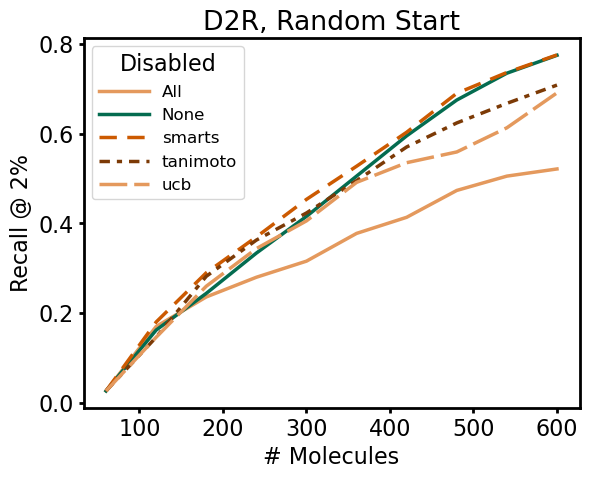

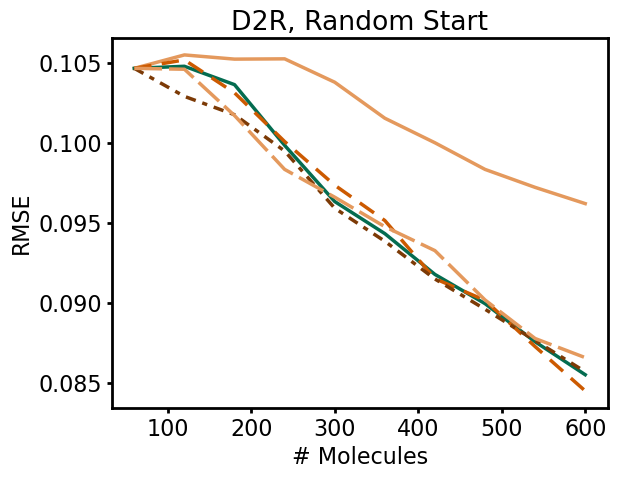

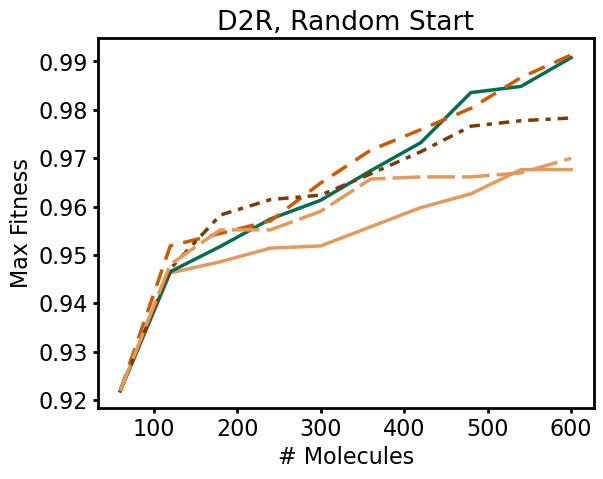

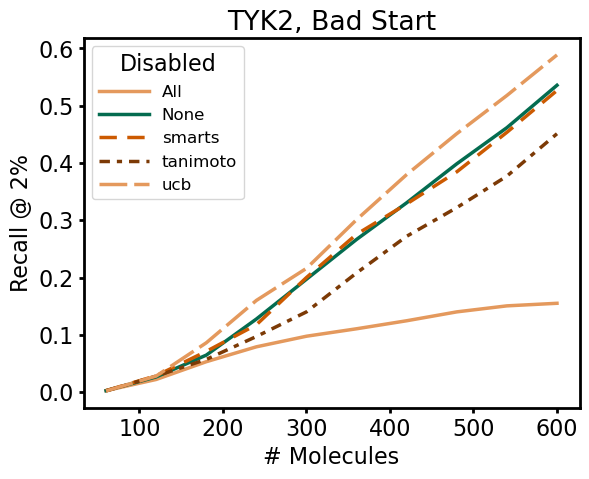

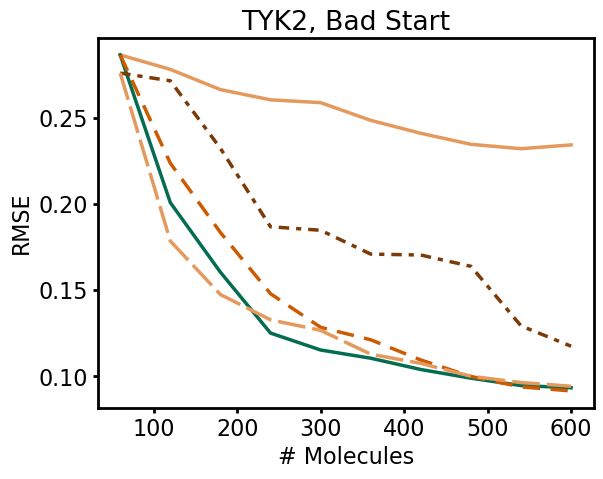

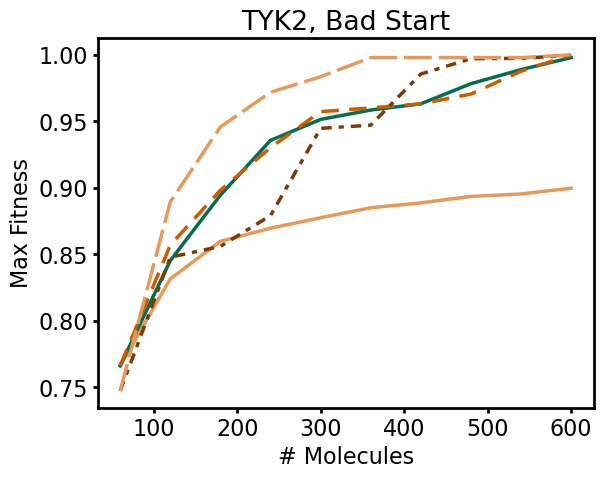

In [38]:
def read_abolition(path):
    files = glob.glob(path)
    dfs = []
    for file in files:
        df = pd.read_csv(file)
        beta = file.split('_')[-1][:-4]
        df['disabled'] = beta
        dfs.append(df)
    return pd.concat(dfs)

abolition_D2R = normalize(read_abolition(path = '../output/benchmarks/benchmark_D2R_GPR*_disable*.csv'), 'D2R')
abolition_TYK2 = normalize(read_abolition(path = '../output/benchmarks/benchmark_TYK2_GPR*_disable*.csv'), 'TYK2')
#simpleagent_D2R = pd.read_csv('/global/cfs/cdirs/m4737/akkem/BO_LLM/mols/output/benchmarks/benchmark_D2R_GPRegOracle_LLMWorkflowSimpleSelector_60_60_Random.csv')
simpleagent_D2R.loc[simpleagent_D2R['Acquisition'] == 'SIMPLEAGENT', 'disabled'] = "None"
simpleagent_D2R.loc[simpleagent_D2R['Acquisition'] == 'GREEDY', 'disabled'] = "All"
#simpleagent_TYK2 = pd.read_csv('/global/cfs/cdirs/m4737/akkem/BO_LLM/mols/output/benchmarks/benchmark_TYK2_GPRegOracle_LLMWorkflowSimpleSelector_60_60_Bad.csv')
simpleagent_TYK2.loc[simpleagent_TYK2['Acquisition'] == 'SIMPLEAGENT', 'disabled'] = "None"
simpleagent_TYK2.loc[simpleagent_TYK2['Acquisition'] == 'GREEDY', 'disabled'] = "All"
abolition_D2R = pd.concat([simpleagent_D2R, abolition_D2R])
abolition_TYK2 = pd.concat([simpleagent_TYK2, abolition_TYK2])
n = 10
se = lambda x : x*stats.t.ppf(0.975, n-1)/np.sqrt(n)
abolition_D2R['recall_2pc_se'] = se(abolition_D2R['recall_2pc_std'])
abolition_TYK2['recall_2pc_se'] = se(abolition_TYK2['recall_2pc_std'])

# Updated plot_abolition function using sns.lineplot like plot_line
def plot_abolition_new(abolition, std=False, title=None, y='recall_2pc', ylabel='Recall @ 2%', legend=True):
    fig, ax = plt.subplots()
    
    # Prepare data like in plot_line function
    df = abolition[['disabled', 'total_labeled', y]].copy()
    if not std:
        df = df.groupby(['disabled', 'total_labeled']).mean().reset_index()
    
    # Create custom palette and dashes for disabled values
    disabled_vals = df['disabled'].unique()
    palette = {}
    dashes = {}
    
    # Get line styles from STYLER dash bank
    dash_bank = STYLER._DASH_BANK
    dash_idx = 0
    
    for disabled_val in disabled_vals:
        if disabled_val == "None":
            # Use STYLER style for SIMPLEAGENT
            palette[disabled_val] = STYLER.palette(['SIMPLEAGENT'])['SIMPLEAGENT']
            dashes[disabled_val] = dash_bank[STYLER.acq_to_idx.get('SIMPLEAGENT', 0) % len(dash_bank)]
        else:
            # Use finetuned color scheme (OI_Vermillion) and different dash styles
            finetuned_cs = STYLER.class_styles["finetuned"]
            cmap = mpl.colormaps.get(finetuned_cs.cmap)
            Q = max(1, finetuned_cs.quantize)
            bin_size = finetuned_cs.span / Q
            bin_idx = dash_idx % Q  # cycle through quantization bins
            center = finetuned_cs.base + (bin_idx + 0.5) * bin_size
            palette[disabled_val] = cmap(min(0.98, max(0.02, center)))
            dashes[disabled_val] = dash_bank[dash_idx % len(dash_bank)]
            dash_idx += 1
    
    # Use seaborn lineplot like plot_line function
    ax = sns.lineplot(data=df, x='total_labeled', y=y, hue='disabled', style='disabled',
                     errorbar=('pi', 100) if std else None, legend=True, ax=ax, 
                     palette=palette, dashes=dashes, **STYLER.line_style())
    
    # Apply same styling as plot_line
    ax.set_axisbelow(True)
    ax.set_ylabel(ylabel)
    ax.set_title(title)   
    if legend:
        ax.legend(fontsize=12, handlelength=3, title='Disabled')
    else:
        ax.legend().remove()
    ax.set_xlabel('# Molecules')
    plt.show()

# Test the new function
plot_abolition_new(abolition_D2R, title='D2R, Random Start')
plot_abolition_new(abolition_D2R, title='D2R, Random Start', y='rmse', ylabel='RMSE', legend=False)
plot_abolition_new(abolition_D2R, title='D2R, Random Start', y='overall_max', ylabel='Max Fitness', legend=False)
plot_abolition_new(abolition_TYK2, title='TYK2, Bad Start')
plot_abolition_new(abolition_TYK2, title='TYK2, Bad Start', y='rmse', ylabel='RMSE', legend=False)
plot_abolition_new(abolition_TYK2, title='TYK2, Bad Start', y='overall_max', ylabel='Max Fitness', legend=False)

